# Imports

In [112]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d

import aespm as ae

In [113]:
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')

from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

cpu


# Interface with Jupiter (local run)

In [114]:
# connection, client = return_connection(host, username, password)

# Read the scan line

# folder = r"C:\Users\Asylum User\Documents\Asylum Research Data\240612\Droplet"

folder = r"C:\Users\Asylum User\Documents\Asylum Research Data\250206\RedSample1"

exp = ae.Experiment(folder=folder)


In [6]:
# # Uncommment this cell the first time the software is being opened


# commands = 'AddEventCallback("ImageUpdt",OverwriteZSensorScope)\n\
# AddEventCallback("ImageUpdt",OverwriteZSensorScope)\n\
# Variable/G Index =0\n\
# ARAddParm("TurnOffAmpSetpointWarning","UserVariablesWave","")\n\
# PV("TurnOffAmpSetpointWarning",1)'

# print(commands)

# ae.write_spm(commands=commands)

In [115]:
## Commonly used custom functions

def load_ibw(self, folder="C:\\Users\\Asylum User\\Documents\\AEtesting\\data_exchange", lines=False, header=False):
    '''
    Read the latest ibw file saved in a given folder.
    '''
    if folder is None:
        fname = ae.get_files(path=self.folder, client=self.client)[0]
    else:
        fname = ae.get_files(path=folder, client=self.client)[0]
    if header is True:
        return ae.tools.load_ibw(fname)
    else:
        return ae.ibw_read(fname, lines=lines, connection=self.connection)

exp.add_func(load_ibw)

def read_meter(self):
    ae.write_spm(commands="GetMeter()", connection=self.connection)
    w = ae.ibw_read(r"C:\Users\Asylum User\Documents\buffer\Meter.ibw", lines=True, connection=self.connection)
    return w

exp.add_func(read_meter)

def ramp_drive_setpoint(self, drive, setpoint):
    commands='SetDriveAmpAndSetpoint({}, {})'.format(drive, setpoint)
    ae.write_spm(commands=commands, connection=self.connection)
    
exp.add_func(ramp_drive_setpoint)

# Function to check the file number in a given folder
def check_files(self, wait=50):
    '''
    Check the number of files in the folder, with 50 s max waiting time.
    '''
    return ae.check_file_number(path=self.folder, retry=int(wait/0.1))
exp.add_func(check_files)

# AC tune the probe and phase
def ac_tune(self, buffer_path=r"C:\Users\Asylum User\Documents\buffer\Tune.ibw", deflection=False):
    if deflection:
        self.execute(action='ZeroPD', wait=5)
    exp.execute('SingleTune', wait=5)
    exp.execute('GetTune', wait=1)
    data = ae.ibw_read(buffer_path).data
    index_max = np.argmax(data[1])
    freq_max = data[0][index_max]
    exp.execute('DriveFreq', value=freq_max, wait=1)
    exp.execute('SinglePhase', wait=5)
    
exp.add_func(ac_tune)

def measure_thres(self, drive, setpoint=0.5, thres=85):
    safe_seed_list = [
        ['DriveAmplitude', drive, 1],
        ['FDTrigger', setpoint * drive * self.param['factor'], 1.5],
        ['SingleForce', None, 1],
        ]
    self.execute_sequence(safe_seed_list)
    self.check_files(wait=20)
    data = self.load_ibw(folder=None, header=True)
    AmpInvOLS = data.header['AmpInvOLS']
    self.update_param('AmpInvOLS', AmpInvOLS)
    fwd, bkd = read_fd(data, factor=self.param['AmpInvOLS'])
    amp_thres = find_thres(fwd[2], fwd[1], thres=thres)
    return amp_thres

exp.add_func(measure_thres)

In [116]:
def read_fd(obj, width=100, factor=None):
    index = np.argmax(obj.data[0])
    fwd = np.zeros([3, width])
    bkd = np.zeros([3, width])
    for i in range(3):
        fwd[i] = obj.data[i][index-width:index]
        bkd[i] = obj.data[i][index:index+width]
    if factor is not None:
        fwd[1] /= factor
        bkd[1] /= factor
    return fwd, bkd        

def find_all_sign_change_indices(arr):
    signs = np.sign(arr)  # Get sign of elements (-1, 0, or 1)
    changes = np.where(signs[:-1] != signs[1:])[0]  # Compare consecutive elements
    return changes
    
def find_thres(ph, amp, thres=80):
    ph_offset = ph - ph[0] + 90
    index = find_all_sign_change_indices(ph_offset-thres)
    if len(index) == 1:
        return amp[index][0]
    elif len(index) > 1:
        return amp[index[0]]
    else:
        return np.nan
    
def conver_unit(p, limits, reverse=False):
    '''
    Project  p from (0, 1) to (p_min, p_max).
    '''
    out = np.zeros_like(p)
    for i in range(len(p)):
        if reverse is False:
            p_min, p_max = limits[i]
            out[i] = p_min + (p_max - p_min) * p[i]
        else:
            p_min, p_max = limits[i]
            out[i] = (p[i] - p_min) / (p_max - p_min)
    return out

# Safe seeding

## Define the parameter limits

In [117]:
# User defines the largest drive voltage as the starting point
drive_limit = 100 * 1e-3 
setpoint_limist = np.array([0.75, 0.5, 0.25])

drives = []
setpoints = []

# Read out all the system parameters
exp.execute('Stop')
exp.execute('DriveAmplitude', drive_limit)

meter = exp.read_meter()

factor = meter[2] / drive_limit
if factor < 1e-1:
    factor *= 1e3

if factor > 5e2:
    factor *= 1e-3

exp.update_param('factor', factor)
print(factor)



8.569025993347168


In [118]:
# Take the first FD curve
# Take a FD curve

safe_seed_list = [
        # ['Stop', None, 1],
        ['DriveAmplitude', drive_limit, 2],
        ['FDTrigger', setpoint_limist[0] * drive_limit * exp.param['factor'], 1.5],
        ['SingleForce', None, 1],
    ]
exp.execute_sequence(safe_seed_list)
exp.check_files(wait=20)

# Read the latest FD curve and compute the threshold setpoint

data = exp.load_ibw(folder=None, header=True)

AmpInvOLS = data.header['AmpInvOLS']

fwd, bkd = read_fd(data, factor=AmpInvOLS)

amp_thres = find_thres(fwd[2], fwd[1], thres=85)

print(amp_thres)

0.7246566089707439


In [119]:
# drive_limits = drive_limit

# n = int(np.log2(drive_limits / 1e-3))

# for i in range(n):
#     amp_thres = exp.measure_thres(drive_limits, setpoint=0.5, thres=85)
#     if amp_thres / (drive_limits*exp.param['factor']) > 0.5:
#         drive_limits /= 2
#     else:
#         drive_limits *= 2
#         break

In [39]:
drive_limits

0.0125

In [120]:
drive_limits = 100e-3

if drive_limits <= 2 * 1e-3:
    print("There is no attractive mode available!")

drives = np.concatenate([np.linspace(1e-3, drive_limits/2.1, 10), np.linspace(drive_limits/2, drive_limits, 5)])[::-1]
thresholds = np.zeros(15)

for i in range(len(drives)):
    print('Working on: {}/{}'.format(i+1, len(drives)), end='\r')
    try:
        amp_thres = exp.measure_thres(drives[i], setpoint=0.25, thres=85)
        thresholds[i] = amp_thres / (drives[i] * exp.param['factor'])
    except ValueError:
        thresholds[i] = np.nan
    
exp.execute('Stop')
# drives

## Visualize the threshold setpoint

In [121]:
thresholds

array([0.90043226, 0.83278136, 0.77994842, 0.71462545, 0.59321077,
       0.55697967, 0.52697111, 0.39926756,        nan, 0.28689061,
              nan,        nan,        nan,        nan,        nan])

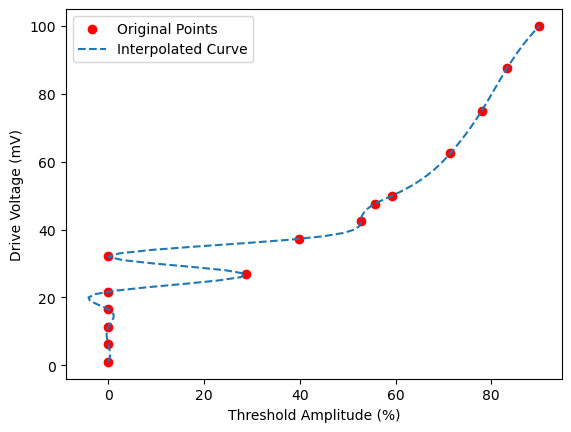

In [122]:
# Interpolate the thresholds as a function of the drives
from scipy.interpolate import interp1d

x = np.array(drives)
y = np.array(thresholds)
y = np.nan_to_num(y)


# Create interpolation function
interp_func = interp1d(x, y, kind='cubic')  # Try 'linear' if issues persist

# Define a denser set of x values
x_dense = np.linspace(min(x), max(x), 100)

# Apply the interpolation function
y_dense = interp_func(x_dense)

# Plot the results
plt.scatter(y * 1e2, x * 1e3, color='red', label="Original Points")
plt.plot(y_dense * 1e2, x_dense * 1e3, label="Interpolated Curve", linestyle='--')
plt.ylabel('Drive Voltage (mV)')
plt.xlabel('Threshold Amplitude (%)')
plt.legend()
plt.show()

## Generate safe parameter space

In [123]:
# Generate the safe parameters for the BO and MOBO

exp.execute('Stop')

# file save name
save_name = 'output/250206_RedSample1_BO'

num1 = 100
num2 = 100

# x1 is the drive
x1 = np.linspace(np.min(drives), np.max(drives), num=num1)
# x2 is the setpoint
x2 = np.linspace(0.1, 0.9, num=num2)
# x3 is the I gain

thres_array = interp_func(x1)

x_exp = []
x_norm = []

safe_factor = 1.1

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

for i in range(len(x1)):
    for j in range(len(x2)):
        # drive = drive_new[i]
        thres_value = thres_array[i] * safe_factor
        if x2[j] > thres_value:
            x_exp.append([x1[i], x2[j]])
            x_norm.append([x1_norm[i], x2_norm[j]])
       
x_exp =  np.asarray(x_exp, dtype=np.float32)
x_norm = np.asarray(x_norm, dtype=np.float32)
X_norm = torch.from_numpy(x_norm)

exp.update_param('X_exp', x_exp)
exp.update_param('X_array', x_norm)
exp.update_param('X_tensor', X_norm)

# Some useful constants in the experiment
exp.update_param('restart', False)
exp.update_param('blueDrive', False)
exp.update_param('global_min', 0)
meter = exp.read_meter()
offset = meter[4] - 90

sca_rate = ae.read_spm(key='ScanRate')
exp.update_param('offset', offset)
exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('ScanRate', sca_rate)

print(exp.param['factor'], exp.param['offset'], exp.param['ScanRate'])

8.569025993347168 0.7836151123046875 1.0016025


Text(0.5, 0, 'Threshold Amplitude (%)')

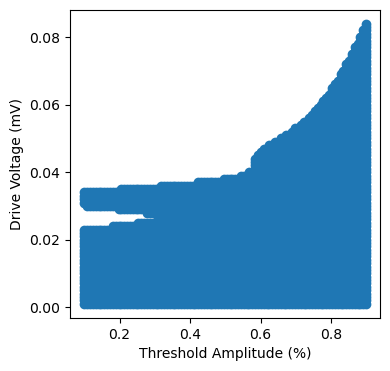

In [125]:
plt.figure(figsize=[4,4])
plt.scatter(x_exp[:,1], x_exp[:,0])
plt.ylabel('Drive Voltage (mV)')
plt.xlabel('Threshold Amplitude (%)')

# BO to find best parameters

## Rewards

In [126]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

def diff_shifted(y1, y2):
    
    # Initial guess for the shift
    initial_shift = 0

    x = np.arange(len(y1))

    # Run the optimization
    result = minimize(mse_shift, initial_shift, args=(x, y1, y2))

    # Best shift found
    best_shift = result.x
    
    # Create a spline of the second trace
    spline = CubicSpline(x, y2)

    # Shift x values by the found optimal shift
    x_shifted = x - best_shift

    # Evaluate the shifted trace at the original x values
    y2_optimal_shifted = spline(x_shifted)
    
    if np.abs(best_shift) > 0.1 * len(y1):
        return y1, y2
    elif best_shift > 0:
        return y1[int(best_shift)+1:], y2_optimal_shifted[int(best_shift)+1:]
    elif best_shift < -1:
        return y1[:int(best_shift)-1], y2_optimal_shifted[:int(best_shift)-1]
    else:
        return y1, y2
    
def mse_shift(shift, x, y1, y2):
    # Create a spline of the second trace
    spline = CubicSpline(x, y2)

    # Shift x values
    x_shifted = x - shift

    # Evaluate the shifted trace at the original x values
    y2_shifted = spline(x_shifted)

    # Compute the MSE between the original and shifted traces
    mse = np.mean((y1 - y2_shifted)**2)
    return mse

def pearson_correlation(ts1, ts2):
    """
    Calculate the Pearson Correlation Coefficient between two time series.
    Assumes both time series are normalized.
    """
    ts1_mean = np.mean(ts1)
    ts2_mean = np.mean(ts2)
    
    numerator = np.sum((ts1 - ts1_mean) * (ts2 - ts2_mean))
    denominator = np.sqrt(np.sum((ts1 - ts1_mean)**2) * np.sum((ts2 - ts2_mean)**2))
    
    return numerator / denominator

In [127]:
norm_ = lambda x: (x-np.min(x)) / np.ptp(x)

def mean_no_outlier(x):
    x_sorted = sorted(np.array(x))
    return np.mean(x_sorted[1:-1])

def reward(self, data):
    
    if np.shape(data)[0] == 8:
        ph1, ph2 = data[4], data[5]
        h1, h2 = data[6]*1e9, data[7] *1e9
#         h1, h2 = data[0]*1e9, data[1] *1e9
    elif np.shape(data)[0] == 4:
        ph1, ph2 = data[2], data[3]
        h1, h2 = data[0]*1e9, data[1] *1e9
        
    # Remove the phase shift
    h1, h2 = diff_shifted(h1, h2)
    
    # Height factor -- favor lower surface height: minimize
    diff = np.abs(h1-h2)
    center =  np.mean(h1+h2)/2

    if center < self.param['global_min']+10:
        self.update_param(key='global_min', value=center-10)

    height_factor = center - self.param['global_min']
    height_factor = max(np.e, height_factor)
    
    # phase below factor: punishes phases below 90-degrees: minimize
    
    # here we mask all the phases above 90-degree to be 90-degree
    # so that they will not contribute to the sum below
    ph1_masked = np.where(ph1 - self.param['offset'] > 90, 90, ph1)
    ph2_masked = np.where(ph2 - self.param['offset'] > 90, 90, ph2)

    # note that smaller the phases are, the larger m1 and m2 will be
    m1 = np.sum(90 + self.param['offset'] - ph1_masked)
    m2 = np.sum(90 + self.param['offset'] - ph2_masked)

    phase_below_factor = max(np.e, m1 * m2)
    
    # Absolute height difference factor: minimize
    # first remove the 2nd order background
    tp1 = ae.tools.lineSubtract(h1, 2)
    tp2 = ae.tools.lineSubtract(h2, 2)
    
    tp1_shift = tp1 - tp1.min() + 1 # prevent dividing by zero error
    tp2_shift = tp2 - tp2.min() + 1 # prevent dividing by zero error
    
    height_trace_factor = np.abs(np.mean(diff / (tp1_shift + tp2_shift))) * 1e2
    
    # trace similarity factor: maximize
    h1_norm, h2_norm = norm_(h1), norm_(h2)
    similarity = (1 - pearson_correlation(h1_norm, h2_norm)) * 10 + np.e
    
    
    base =  height_trace_factor * np.log(height_factor) * np.log(phase_below_factor) * np.log(similarity) 
    
    print(height_trace_factor, np.log(height_factor), np.log(phase_below_factor), np.log(similarity))
    print('Reward={}'.format(-np.log(np.abs(base))))
    return -np.log(np.abs(base))

def measure(self, v_ac, setpoint, i_gain=None, restart=False, blueDrive=False, 
            repeat=1, reward=True, wait=1):

    if restart:
        self.execute(action='Stop', wait=1, connection=self.connection)
        if blueDrive is True:
            self.execute(action='BlueDriveAmplitude', value=v_ac * 1e-3, wait=2, connection=self.connection)
            setpoint_ac = setpoint * v_ac * self.param['factor'] * 1e-3
        else:
            self.execute(action='DriveAmplitude', value=v_ac, wait=2, connection=self.connection)
            setpoint_ac = setpoint * v_ac * self.param['factor'] 
        self.execute(action='SetpointAmp', value=setpoint_ac, wait=1.5, connection=self.connection)
        
        if i_gain is not None:
            self.execute('IGain', value=i_gain, wait=1.5, connection=self.connection)
        self.execute('DownScan', wait=2 + 2, connection=self.connection)
    
    else:
        self.execute('ramp_drive_setpoint', value=[v_ac, setpoint * v_ac * self.param['factor']], wait=0.5)
        if i_gain is not None:
            self.execute('IGain', value=i_gain, wait=1.5, connection=self.connection)
    
    reward_out = []
    w_out = []
    
    time.sleep(3)
    
    if repeat > 1:
        for i in range(repeat):
            w = self.load_ibw(folder=self.temp_folder, lines=True)
            w_out.append(w)
            if reward == True:
                reward_out.append(self.reward(w))
            time.sleep(2/self.param['ScanRate'])
            
        if reward == True:
            return np.array(w_out), mean_no_outlier(reward_out)
        else:
            return np.array(w_out)
    
    else:
        w = self.load_ibw(folder=self.temp_folder, lines=True)
        reward_out = self.reward(w)
        if reward == True:
            return w, reward_out
        else:
            return w
        
exp.add_func(reward)
exp.add_func(measure)

## Random seeding

In [128]:
def norm_reward(x):
    x_center = x - np.mean(x) # -0.1
    return x_center / np.std(x_center)

def generate_seed(self, num=15, safe=False, repeat=1, rand=False, blueDrive=False, save=None):
    
    X = self.param['X_array']
    
    np.random.seed(35)
    idx = np.random.randint(0, len(X), num)
    
    X_measured = X[idx]
    X_exp_measured = self.param['X_exp'][idx]
    
    y_measured = np.zeros(len(idx))
    
    indices_measured = idx
    indices_unmeasured = np.delete(np.arange(len(X)), idx, 0)

    self.update_param('num_seed', num)
    self.update_param('idx', idx)
    self.update_param('indices_unmeasured_seed', indices_unmeasured)
    self.update_param('indices_measured_seed', indices_measured)
    
    if repeat == 1:
        out = np.zeros([num, 8, 256])
    else:
        out = np.zeros([num, repeat, 8, 256])
    
    for i in range(len(idx)):
        if len(X_exp_measured[i])==2:
            v_ac, setpoint = X_exp_measured[i]
            i_gain = None
        else:
            v_ac, setpoint, i_gain = X_exp_measured[i]
            
        w, rew = self.measure(v_ac=v_ac, setpoint=setpoint, i_gain=i_gain, restart=True, wait=1, 
                              reward=True, repeat=repeat, blueDrive=self.param['blueDrive'])
        
        out[i] = w
        
        y_measured[i] = rew
        
        if repeat > 1:
            plot_seed(w[-1], i)
        else:
            plot_seed(w, i)

    out = np.array(out)
    self.execute('Stop')    
    X_unmeasured = np.delete(X, idx, axis=0)
    X_exp_unmeasured = np.delete(self.param['X_exp'], idx, axis=0)

    if repeat == 1:
        self.update_param('global_min', np.min(out[:,0:2,:]) * 1e9 - 10)
    else:
        self.update_param('global_min', np.min(out[:,:,0:2,:]) * 1e9 - 10)

    y_measured = np.asarray(y_measured, dtype=np.float32)
    
    if save is not None:
        np.savez('{}.npz'.format(save), X_measured=X_measured, X_exp_measured=X_exp_measured, y_measured=y_measured, traces=out)
    plt.figure(figsize=[4,3])
    plt.scatter(X_exp_measured[:, 1], X_exp_measured[:, 0], c=y_measured, s=160, marker='s')
    plt.xlabel('Setpoint (x Free amp)')
    plt.ylabel('Drive Voltage (V)')
    plt.tight_layout()
    
    self.update_param('X_measured_array_seed', X_measured)
    
    self.update_param('X_exp_measured', X_exp_measured)
    self.update_param('X_exp_unmeasured', X_exp_unmeasured)
    
    self.update_param('X_exp_measured_seed', X_exp_measured)
    self.update_param('X_exp_unmeasured_seed', X_exp_unmeasured)
    
    self.update_param('X_unmeasured_array_seed', X_unmeasured)
    self.update_param('y_measured_array_seed', y_measured)
    
    self.update_param('X_measured_tensor_seed', torch.from_numpy(X_measured))
    self.update_param('X_unmeasured_tensor_seed', torch.from_numpy(X_unmeasured))
    self.update_param('y_measured_tensor_seed', torch.from_numpy(y_measured))
    

def plot_seed(w, i, fd=False):
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(7, 3), dpi=200)
    
    if fd == True:
        ax[0].plot(w[0], w[1], '.-')
        ax[0].set_xlabel('Pixels')
        ax[0].set_ylabel('Height (m)')
        ax[0].set_title("Traces at sample={}".format(i+1))
        ax[1].plot(w[0], w[2], '.-')
        ax[1].axhline(90, linestyle='--', color='r')
        ax[1].set_xlabel('Pixels')
        ax[1].set_ylabel('Phase')
        ax[1].set_title("Phases")
        plt.tight_layout()
        plt.show()
                
    else:
        # global global_min
        if np.shape(w)[0] == 8:
            ph1, ph2 = w[4], w[5]
            h1, h2 = w[6]*1e9, w[7] *1e9
        elif np.shape(w)[0] == 4:
            ph1, ph2 = w[2], w[3]
            h1, h2 = w[0]*1e9, w[1] *1e9
        ax[0].plot(h1)
        ax[0].plot(h2)
        ax[0].set_xlabel('Pixels')
        ax[0].set_ylabel('Height (nm)')
        ax[0].set_title("Traces at sample={}".format(i+1))
        ax[1].plot(ph1)
        ax[1].plot(ph2)
        ax[1].axhline(90, linestyle='--', color='r')
        ax[1].set_xlabel('Pixels')
        ax[1].set_ylabel('Phase')
        ax[1].set_title("Phases")
        plt.tight_layout()
        plt.show()
        
exp.add_func(generate_seed)

## BO exploration functions

In [129]:
def step(self, acquisition='EI', beta=4):
    y_measured_tensor = torch.tensor(self.param['y_measured_tensor'], dtype=torch.float32)
    gp_model = SingleTaskGP(self.param['X_measured_tensor'], torch.unsqueeze(y_measured_tensor, dim=-1))
    
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    fit_gpytorch_mll(mll)
    
    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(self.param['X_unmeasured_tensor'])
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()
    
    # Compute acquisition function (Expected Improvement here)

    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    elif acquisition=='EI':
        # EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        EI = LogExpectedImprovement(model=gp_model, best_f=y_measured_tensor.max(), maximize=True)
        acq_values = EI(self.param['X_unmeasured_tensor'].unsqueeze(-2))
    else:
        return 0
    
    self.update_param('acq_tensor', acq_values)
    self.update_param('y_pred_tensor', y_pred)
    self.update_param('y_sampled_tensor', y_sampled)
    
    self.update_param('acq_array', acq_values.detach().numpy())
    self.update_param('y_pred_array', y_pred.detach().numpy())
    self.update_param('y_sampled_array', y_sampled.detach().numpy())
    

def plot_bo(self, title=''):
    
    X_measured = self.param['X_exp_measured']
    X_unmeasured = self.param['X_exp_unmeasured']
    
    y_measured = self.param['y_measured_array']
    acq = self.param['acq_masked']
    y_pred = self.param['y_pred_array']
    y_sampled = self.param['y_sampled_array']
    num_seed = self.param['num_seed']
    
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    im1 = ax[0].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, s=40, cmap='jet')
    ax[0].set_title("{}".format(title))
    
    im2 = ax[1].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=acq, s=40, cmap='jet')
    ax[1].set_title("Acquisition")
    
    ax[2].scatter(X_unmeasured[:, 1], X_unmeasured[:, 0], c=y_pred, cmap='gray')
    ax[2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')
    
    im3 = ax[2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,
                        c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
    ax[2].set_title("BO trajectory")
    
    for axis in ax:
        axis.set_xlabel('Setpoint (xFree amp)')
        axis.set_ylabel('Drive Voltage (V)')
        
    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.colorbar(im3, ax=ax[2])
    plt.tight_layout()
    plt.show()

# Active learning

def run_BO(self, mask=None, fresh=True, num_steps=30, repeat=1,
           show=True, acquisition='EI', beta=4, save=None):
    
    import warnings
    
    warnings.filterwarnings('ignore')

    waves = np.zeros([num_steps, repeat, 8, 256])
    
    if fresh:
        self.update_param('X_measured_array', self.param['X_measured_array_seed'])
        self.update_param('X_unmeasured_array', self.param['X_unmeasured_array_seed'])
        self.update_param('y_measured_array', self.param['y_measured_array_seed'])
        
        self.update_param('X_exp_measured', self.param['X_exp_measured_seed'])
        self.update_param('X_exp_unmeasured', self.param['X_exp_unmeasured_seed'])

        self.update_param('X_measured_tensor', self.param['X_measured_tensor_seed'])
        self.update_param('X_unmeasured_tensor', self.param['X_unmeasured_tensor_seed'])
        self.update_param('y_measured_tensor', self.param['y_measured_tensor_seed'])
        
        self.update_param('indices_measured', self.param['indices_measured_seed'])
        self.update_param('indices_unmeasured', self.param['indices_unmeasured_seed'])
    
    y_measured = self.param['y_measured_tensor']
    X_measured = self.param['X_measured_tensor']
    X_unmeasured = self.param['X_unmeasured_tensor']
    
    X_exp_measured = self.param['X_exp_measured']
    X_exp_unmeasured = self.param['X_exp_unmeasured']
        
    for e in range(num_steps):
      
        self.step(acquisition=acquisition, beta=beta)

        if mask is None:
            acq_masked = self.param['acq_array']
        else:
            acq = self.param['acq_array']
            acq_masked = (acq-acq.min()) * mask.flatten()[self.param['indices_unmeasured']]
            
        self.update_param('acq_masked', acq_masked)
        
        next_idx = acq_masked.argmax()
        next_point_exp = X_exp_unmeasured[next_idx]
        next_point = X_unmeasured[next_idx]
        
        if len(next_point_exp) == 2:
            v_ac, setpoint = next_point_exp
            i_gain = None
        else:
            v_ac, setpoint, i_gain = next_point_exp
        if not e:
            w, next_measure = self.measure(v_ac=v_ac, setpoint=setpoint, i_gain=i_gain,
                                           reward=True, repeat=repeat, restart=True, wait=1.5)
        else:
            w, next_measure = self.measure(v_ac=v_ac, setpoint=setpoint, i_gain=i_gain,
                                           reward=True, repeat=repeat, restart=self.param['restart'], wait=1.5)
        waves[e] = w
        
        if show is True:
            self.plot_bo(title='Prediction at {}'.format(e+1))
            
        next_point = torch.tensor(next_point, dtype=torch.float32)
        next_measure = torch.tensor([next_measure], dtype=torch.float32)
        
        y_measured = torch.cat((y_measured, next_measure), axis=0)
        
        X_measured = torch.cat((X_measured, next_point.unsqueeze(-2)), axis=0)
        
        X_unmeasured = torch.tensor(np.delete(X_unmeasured, next_idx, axis=0), dtype=torch.float32)
            
        X_exp_measured =  np.concatenate((self.param['X_exp_measured'], [next_point_exp]), axis=0)
        X_exp_unmeasured = np.delete(X_exp_unmeasured, next_idx, axis=0)
        self.update_param('X_exp_measured', X_exp_measured)
        self.update_param('X_exp_unmeasured', X_exp_unmeasured)
        
        self.update_param('X_measured_tensor', X_measured)
        self.update_param('X_unmeasured_tensor', X_unmeasured)
        self.update_param('y_measured_tensor', y_measured)

        self.update_param('X_measured_array', X_measured.detach().numpy())
        self.update_param('X_unmeasured_array', X_unmeasured.detach().numpy())
        self.update_param('y_measured_array', y_measured.detach().numpy())
    
        self.update_param('indices_measured', np.concatenate((self.param['indices_measured'], [next_idx])))
        self.update_param('indices_unmeasured', np.delete(self.param['indices_unmeasured'], next_idx))
        
    self.execute('Stop')
    
    if save is not None:
        np.savez('{}.npz'.format(save), X_measured=X_measured, X_unmeasured=X_unmeasured, X_exp_measured=X_exp_measured, X_exp_unmeasured=X_exp_unmeasured,
             y_measured=y_measured, traces=waves)

# Visualize the training result
def train_BO(self, acquisition='EI', beta=4):
    
    X = self.param['X_tensor']
    X_measured = self.param['X_measured_tensor']
    y_measured = torch.tensor(self.param['y_measured_tensor'], dtype=torch.float32)
    
    gp_model = SingleTaskGP(X_measured, torch.unsqueeze(y_measured, dim=-1))
    # Fit GP model
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    fit_gpytorch_mll(mll)
    
    # Predict on unmeasured data
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        posterior = gp_model(X)
        # For visualization or further processing, you can obtain mean and variance
        y_pred = posterior.mean
        y_sampled = posterior.variance.sqrt()
        
    if acquisition=='UCB':
        UCB = UpperConfidenceBound(model=gp_model, beta=beta)
        acq_values = UCB(X.unsqueeze(-2))
    elif acquisition=='EI':
        EI = ExpectedImprovement(model=gp_model, best_f=y_measured.max(), maximize=True)
        acq_values = EI(X.unsqueeze(-2))
    else:
        return 0
    
    self.update_param('acq_tensor', acq_values)
    self.update_param('y_pred_tensor', y_pred)
    self.update_param('y_sampled_tensor', y_sampled)
    
    self.update_param('acq_array', acq_values.detach().numpy())
    self.update_param('y_pred_array', y_pred.detach().numpy())
    self.update_param('y_sampled_array', y_sampled.detach().numpy())
    
exp.add_func(step)
exp.add_func(plot_bo)
exp.add_func(run_BO)
exp.add_func(train_BO)
# exp.add_func(acq_mask)

In [130]:
def acq_mask(self, center, width, amp, thres=None, show=False):
    '''
    center: [x0, y0]
    width: [wx, wy]
    amp: 0-1
    '''
    
    X = self.param['X_array']
    if X.shape[-1] == 2:
        
        t1 = np.arange(self.param['num1'])
        t2 = np.arange(self.param['num2'])
        x, y = np.meshgrid(t1, t2)

        g = amp*np.exp(-((x-center[0])**2/width[0]**2 + (y-center[1])**2/width[1]**2)) + (1-amp)
        if thres is not None:
            g[np.where(g > thres)] = thres
        if show:
            plt.figure(figsize=[4,4])
            plt.imshow(g, origin='lower')
            plt.colorbar()
            
    elif X.shape[-1] == 3:
        t1 = np.arange(self.param['num1'])
        t2 = np.arange(self.param['num2'])
        t3 = np.arange(self.param['num3'])
        
        x, y, z = np.meshgrid(t1, t2, t3)

        g = amp*np.exp(-((x-center[0])**2/width[0]**2 + (y-center[1])**2/width[1]**2 + (z-center[2])**2/width[2]**2)) + (1-amp)
        if thres is not None:
            g[np.where(g > thres)] = thres
        
    return g

exp.add_func(acq_mask)

## Initialization variables

In [131]:
# Generate the safe parameters for the BO and MOBO

exp.execute('Stop')

# file save name
save_name = 'output/250206_RedSample1_BO'

num1 = 100
num2 = 100

# x1 is the drive
x1 = np.linspace(np.min(drives), np.max(drives), num=num1)
# x2 is the setpoint
x2 = np.linspace(0.1, 0.9, num=num2)
# x3 is the I gain

thres_array = interp_func(x1)

x_exp = []
x_norm = []

safe_factor = 1.1

x1_norm = np.linspace(0, 1, num=num1)
x2_norm = np.linspace(0, 1, num=num2)

for i in range(len(x1)):
    for j in range(len(x2)):
        # drive = drive_new[i]
        thres_value = thres_array[i] * safe_factor
        if x2[j] > thres_value:
            x_exp.append([x1[i], x2[j]])
            x_norm.append([x1_norm[i], x2_norm[j]])
       
x_exp =  np.asarray(x_exp, dtype=np.float32)
x_norm = np.asarray(x_norm, dtype=np.float32)
X_norm = torch.from_numpy(x_norm)

exp.update_param('X_exp', x_exp)
exp.update_param('X_array', x_norm)
exp.update_param('X_tensor', X_norm)

# Some useful constants in the experiment
exp.update_param('restart', False)
exp.update_param('blueDrive', False)
exp.update_param('global_min', 0)
meter = exp.read_meter()
offset = meter[4] - 90
factor = meter[2] / ae.read_spm(key='DriveAmplitude') 
if factor < 1e-1:
    factor *= 1e3

if factor > 5e2:
    factor *= 1e-3
    

sca_rate = ae.read_spm(key='ScanRate')
exp.update_param('offset', offset)
exp.update_param('factor', factor)
exp.update_param('num1', num1)
exp.update_param('num2', num2)
exp.update_param('ScanRate', sca_rate)

print(exp.param['factor'], exp.param['offset'], exp.param['ScanRate'])

8.919834912240509 0.8549346923828125 1.0016025


## Generate seeds

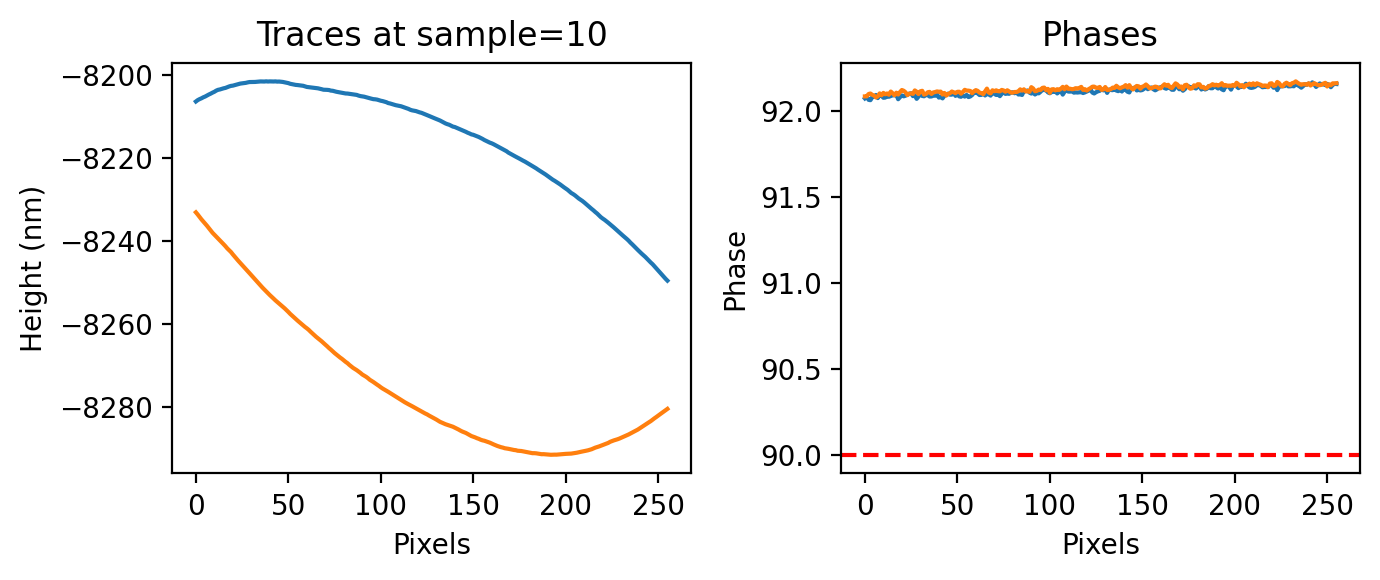

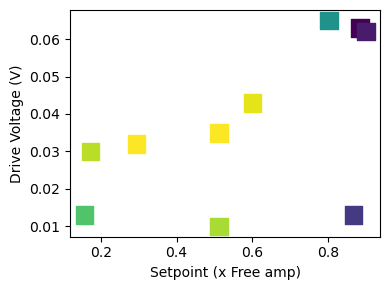

In [132]:
exp.generate_seed(num=10, repeat=5, save=save_name+'seeding')

In [133]:
import pickle

with open('{} seeding.pickle'.format(save_name), 'wb') as file:
    pickle.dump(exp.param, file)

## BO training (without mask)

In [134]:
exp.execute('ChangeName', 'Red1_training_')
time.sleep(2)

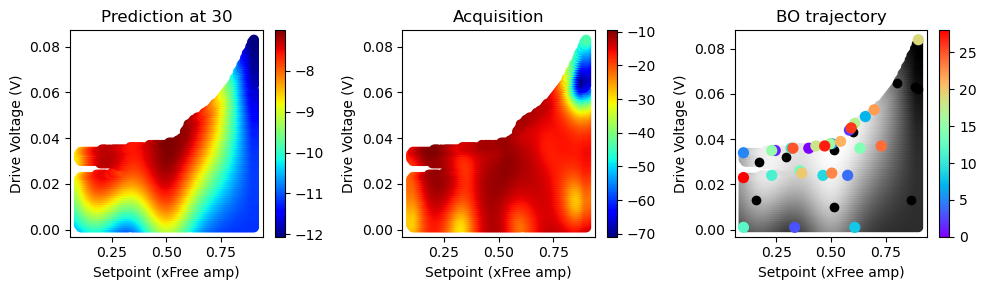

In [135]:
exp.run_BO(mask=None, num_steps=30, repeat=5, show=True, fresh=True,
           acquisition='EI', save=save_name)

In [136]:
with open('{} training.pickle'.format(save_name), 'wb') as file:
    pickle.dump(exp.param, file)

## Take a scan with optimized parameters

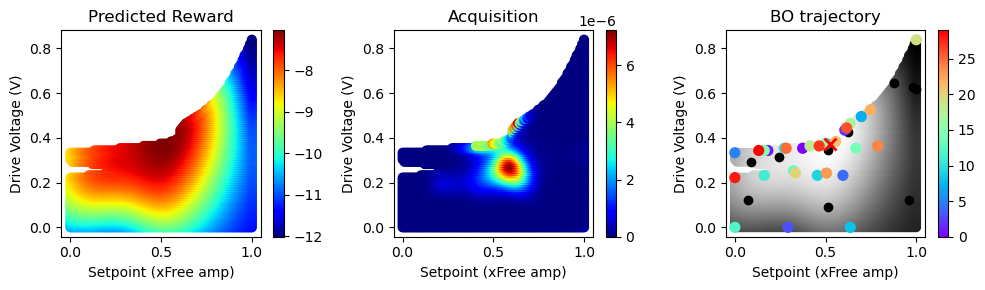

In [137]:
exp.train_BO(acquisition='EI', beta=4)

X_measured = exp.param['X_measured_array']
y_measured = exp.param['y_measured_array']
acq = exp.param['acq_array']
y_pred = exp.param['y_pred_array']
y_sampled = exp.param['y_sampled_array']
X = exp.param['X_array']
num_seed = exp.param['num_seed']

index_min = y_pred.argmax()

# num_seed = 10

_, ax = plt.subplots(1, 3, figsize=(10, 3))
im1 = ax[0].scatter(X[:, 1], X[:, 0], c=y_pred, s=40, cmap='jet')
ax[0].set_title("Predicted Reward")
im2 = ax[1].scatter(X[:, 1], X[:, 0], c=acq, s=40, cmap='jet')
ax[1].set_title("Acquisition")

ax[2].scatter(X[:, 1], X[:, 0], c=y_pred, cmap='gray')
ax[2].scatter(X_measured[:num_seed,1], X_measured[:num_seed,0], c = 'k')
im3 = ax[2].scatter(X_measured[num_seed:, 1], X_measured[num_seed:, 0], marker='o', s=50,c = np.arange(len(X_measured)-num_seed), cmap = 'rainbow')
ax[2].plot(X[index_min][1], X[index_min][0], 'rx', ms=8, mew=2)

ax[2].set_title("BO trajectory")
for axis in ax:
    axis.set_xlabel('Setpoint (xFree amp)')
    axis.set_ylabel('Drive Voltage (V)')
    
plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])
plt.tight_layout()

# plt.savefig('figs/ucb training reward.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

In [138]:
index_min = y_pred.argmax()
# X = exp.param['X_array']
X = exp.param['X_exp']

v_ac_op = X[index_min][0]
setpoint_op = v_ac_op * X[index_min][1] * exp.param['factor']

print("Optimized drive voltage: {:.06f} V".format(v_ac_op))
print("Optimized setpoint: {:.06f} V".format(setpoint_op))

exp.execute('DriveAmp', value=v_ac_op, wait=0.5)
exp.execute('SetpointAmp', value=setpoint_op, wait=0.5)

Optimized drive voltage: 0.038000 V
Optimized setpoint: 0.176324 V
